# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.

Good luck & have fun! :)

In [1]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

**✨ Внимание ✨**

В этом домашнем задании предлагается использовать библиотеку `pytorch_lightning`. Доступ к ее [документации](https://lightning.ai/docs/pytorch/stable/) заблокирован с территории РФ. Вы можете:

1. Получить к ней доступ с помощью VPN.

2. Собрать документацию самостоятельно. Для этого склонируйте [github-репозиторий](https://github.com/Lightning-AI/lightning/tree/master), запустите в нем терминал (на windows – git bash) и выполните команды:

```shell
git submodule update --init --recursive
make docs
```
После этого откройте появившийся файл `docs/build/html/index.html`. Для работы команд в вашем окружении должен быть `pip`. Полная инструкция [по ссылке](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Гуглить `<error message> pytorch lightning` или `<how to do this> pytorch lightning`. Stack overflow на территории РФ все еще доступен 😉

4. Не пользоваться `pytorch_lightning` и написать цикл обучения модели самостоятельно. Например, по аналогии с функцией `fit` из [семинара 4](https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/04.%20Optim%20%26%20Lightning/04_Optim%26Lightning_solution.ipynb).

In [1]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2023-11-12 15:16:38--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2023-11-12 15:16:39--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3d719a5fb4185e936ea055c0d3.dl.dropboxusercontent.com/cd/0/get/CHZD6mwl2i_N_J6hcyLpYw38xaRpdvffTyMhpES4DeHSqp24qZDdJhyOYU9HxflFmSN6quUTwrDMmybAd1dLKqPLKk7BFdbqSXU5BLA7svAZDkoQy7NSRw7M1p3SygGoeB6h81SDoBdLCmrFGc-OT1wJ/file?dl=1# [following]
--2023-11-12 15:16:39--  https://uc3d719a5fb4185e936ea055c0d3.dl.dropboxusercontent.com/cd/0/get/CHZD6mwl2i_N_J6hcyLpYw38xaRpdvffTyMhpES4DeHSqp24qZDdJhyOYU9HxflFmSN6quUTwrDMmybAd1dLKqPLKk7BFdbqSXU5BLA

In [3]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

# You may add any imports you need

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [26]:
# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform =  transforms.Compose([
    transforms.RandomRotation(10),  # Случайный поворот на ±10 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Изменение цвета
    transforms.RandomHorizontalFlip(),  # Отражение по горизонтали
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.4830, 0.4519, 0.4022], std=[0.2747, 0.2673, 0.2805])  # Нормализация
])

val_transform =    transforms.Compose([
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.4830, 0.4519, 0.4022], std=[0.2747, 0.2673, 0.2805])  # Нормализация
])

train_dataset = ImageFolder('dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle = True, num_workers=2) # YOUR CODE HERE
val_dataloader = DataLoader(val_dataset, batch_size = 256, shuffle = False, num_workers=2) # YOUR CODE HERE

In [10]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

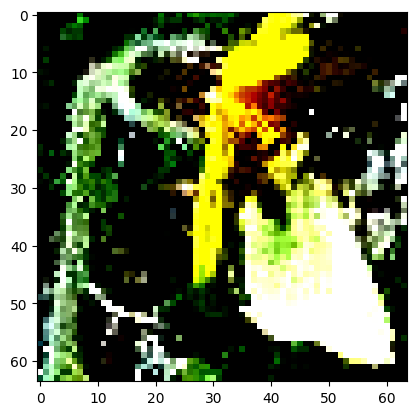

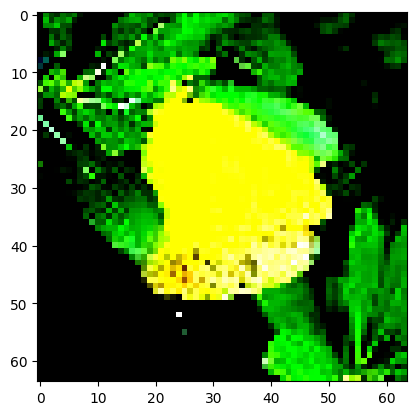

In [11]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1.

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [22]:
class YourNet6(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 256, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(512, 500, kernel_size=5, stride=1, padding=2)
        
        self.drop = nn.Dropout(0.2)

        self.relu = nn.LeakyReLU()
        self.linear_unite = nn.Linear(in_features = 500*2*2, out_features = 500)
        self.linear_last = nn.Linear(in_features = 500, out_features = 200)

        self.bn1 = nn.BatchNorm1d(500*2*2)
        self.bn2 = nn.BatchNorm1d(500)

    def forward(self, images, target=None):
        images = self.relu(self.conv1(images))
        images = self.pool(self.relu(self.conv2(images)))
        images = self.pool2(self.relu(self.conv3(images)))
        images = self.pool2(self.relu(self.conv4(images)))
        pred = images.reshape(images.shape[0], -1)
        pred = self.drop(self.bn1(pred))
        pred = self.drop(self.bn2(self.relu(self.linear_unite(pred))))
        pred = self.linear_last(pred)
        return pred


### Тренировочный класс lightning

In [23]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = StepLR(self.optimizer, step_size=400, gamma=0.95)
        self.save_hyperparameters()
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.scheduler.step()
        self.log("train_loss", loss, prog_bar=True)
        self.log("lr", self.optimizer.param_groups[0]['lr'], prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task='multiclass', num_classes=200)
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [18]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = YourNet6()
module = YourModule(model, 1e-3).to(device)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [19]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checks/task1',
    filename='model-{epoch:02d}-{accuracy:.2f}',
    monitor='accuracy',
    mode='max',
    save_top_k=3
)
trainer = pl.Trainer(accelerator='auto', logger=wandb_logger, max_epochs=50, callbacks=[checkpoint_callback])  # YOUR CODE HERE
trainer.fit(module, train_dataloader, val_dataloader)  # YOUR CODE HERE

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /kaggle/working/checks/task1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [20]:
wandb.finish()

accuracy,▁▄▅▆▇▇▇▇▇█████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
lr,██▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
train_loss,█▇▆▅▄▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▂▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.4665
epoch,18
lr,0.00042
train_loss,1.04837
trainer/global_step,7049


### Валидация результатов задания

In [21]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    acc = 0.0
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model.training_step((images, labels), None)
            acc_batch = accuracy(torch.argmax(model(images), dim=-1).long(), labels.long(), task='multiclass', num_classes=200)
        acc += acc_batch
    acc = acc / len(test_dataloader)
    return acc.cpu()

In [22]:
model = YourModule.load_from_checkpoint('checks/task1/model-epoch=15-accuracy=0.47.ckpt')

acc = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * acc / 0.44, 0, 10):.2f} баллов")

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/core/module.py:413: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


Оценка за это задание составит 10.00 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [5]:
# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),  # Случайный поворот на ±10 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Изменение цвета
    transforms.RandomHorizontalFlip(),  # Отражение по горизонтали
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

val_transform =    transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.4830, 0.4519, 0.4022], std=[0.2747, 0.2673, 0.2805])  # Нормализация
])

train_dataset = ImageFolder('dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers=4) # YOUR CODE HERE
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle = False, num_workers=4) # YOUR CODE HERE

In [9]:
from itertools import chain
class YourNet4(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.drop = nn.Dropout(0.2)

        self.model1 = torchvision.models.efficientnet_v2_s(pretrained = True).to(device)
        self.model1.classifier = nn.Identity()
        
        self.linear_last = nn.Sequential(
            nn.LeakyReLU(),
            nn.BatchNorm1d(1280),
            self.drop,
            nn.Linear(in_features=1280, out_features=500, bias=True),
            nn.LeakyReLU(),
            nn.BatchNorm1d(500),
            self.drop,
            nn.Linear(in_features = 500, out_features = 200),
        )

        

    def _forward(self, x):
        pred1 = self.model1(x)
        pred = self.linear_last(pred1)
        return pred

    def forward(self, images, target=None):
        return self._forward(images)

    def freeze_parameters(self, freeze = True):
        for param in self.model1.parameters():
            param.requires_grad = False

            
    def _unfreeze_one_model(self, model, num_to_unfreeze=1):
        params = list(model.parameters())
        num_unfeezed = 0
        for i in range(len(params)-1, -1, -1):
            param = params[i]
            if not param.requires_grad:
                param.requires_grad = True
                num_unfeezed += 1
            
            if num_unfeezed == num_to_unfreeze:
                return
    
    def unfreeze_parameters(self, num_to_unfreeze=1):
        self._unfreeze_one_model(self.model1, num_to_unfreeze)
    

### Тренировочный класс lightning

In [39]:
class CustomScheduler:
    def __init__(self, param_group, step_size, gamma, num_epoch=10**10):
        self.cur_step = 0
        self.gamma = gamma
        self.step_size = step_size
        self.max_iter= num_epoch * step_size
        self.param_group = param_group
    
    def step(self):
        if self.cur_step > self.max_iter:
            return
        self.cur_step+=1
        if self.cur_step % self.step_size == 0:
            self.param_group['lr'] *= self.gamma

In [40]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate1, learning_rate2):
        super().__init__()
        self.model = model
        params_group1 = {'params': model.linear_last.parameters(), 'lr': learning_rate1}
        params_group2 = {'params': model.model1.parameters(), 'lr': learning_rate2}
        self.optimizer = torch.optim.Adam([params_group1, params_group2])
        self.scheduler1 = CustomScheduler(self.optimizer.param_groups[0], step_size=1563, gamma=0.65)
        self.scheduler2 = CustomScheduler(self.optimizer.param_groups[1], step_size=1563, gamma=2)
        self.save_hyperparameters()
        self.loss = nn.CrossEntropyLoss()
        
        self.model.freeze_parameters()
    ##    self.automatic_optimization = False
        self.cur_step = 0

    def forward(self, x):
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
#         self.optimizer1.zero_grad()
#         self.optimizer2.zero_grad()
        self.cur_step += 1
        if self.cur_step == 1600:
            self.model.unfreeze_parameters(1000)
            
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
   #     loss.backward()
#         self.optimizer1.step()
#         self.optimizer2.step()
        if self.current_epoch < 6:
            self.scheduler1.step()
            self.scheduler2.step()
        self.log("train_loss", loss, prog_bar=True)
        self.log("lr1", self.optimizer.param_groups[0]['lr'], prog_bar=True)
        self.log("lr2", self.optimizer.param_groups[1]['lr'], prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task='multiclass', num_classes=200)
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [41]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = YourNet4()
module = YourModule(model, 1e-3, 1e-6).to(device)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:398: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/u

In [42]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checks/task2',
    filename='model-{epoch:02d}-{accuracy:.2f}',
    monitor='accuracy',
    mode='max',
    save_top_k=3
)
trainer = pl.Trainer(accelerator='auto', logger=wandb_logger, max_epochs=10, callbacks=[checkpoint_callback])  # YOUR CODE HERE

trainer.fit(module, train_dataloader, val_dataloader)  # YOUR CODE HERE

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /kaggle/working/checks/task2 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [43]:
wandb.finish()

accuracy,▁▅▆▇██
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
lr1,███████▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
lr2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄█
train_loss,█▆▇▅▅▆▆▅▅▅▄▅▃▄▃▃▄▄▃▃▂▃▃▃▂▂▃▁▂▁▂▁▂▁▃▂▁▂▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▃▂▁▁
accuracy,0.8481
epoch,6
lr1,8e-05
lr2,6e-05


### Валидация результатов задания

In [44]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    acc = 0.0
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model.training_step((images, labels), None)
            acc_batch = accuracy(torch.argmax(model(images), dim=-1).long(), labels.long(), task='multiclass', num_classes=200)
        acc += acc_batch
    acc = acc / len(test_dataloader)
    return acc.cpu()

In [45]:
model = YourModule.load_from_checkpoint('checks/task2/model-epoch=05-accuracy=0.85.ckpt')

accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/core/module.py:413: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


Оценка за это задание составит 10.00 баллов


# Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

# Задание 1
 
Сначала долгое время (около 30 экспов) я пробовал готовые небольшие модели. Небольшие потому что наш датасет не очень большой. Они не очень работали, я думаю, что это потому что наш датасет маленький даже для них, а еще размер картинок у нас слишком маленький для этих моделей. Также я пробовал ансамблировать небольшие модели, брал их штук 5, но все равно accuracy не было больше 35%. Тогда я понял, что готовые модели не очень для наших данных и построил свою очень маленькую сетку. Почти сходу выбил 46% accuracy.
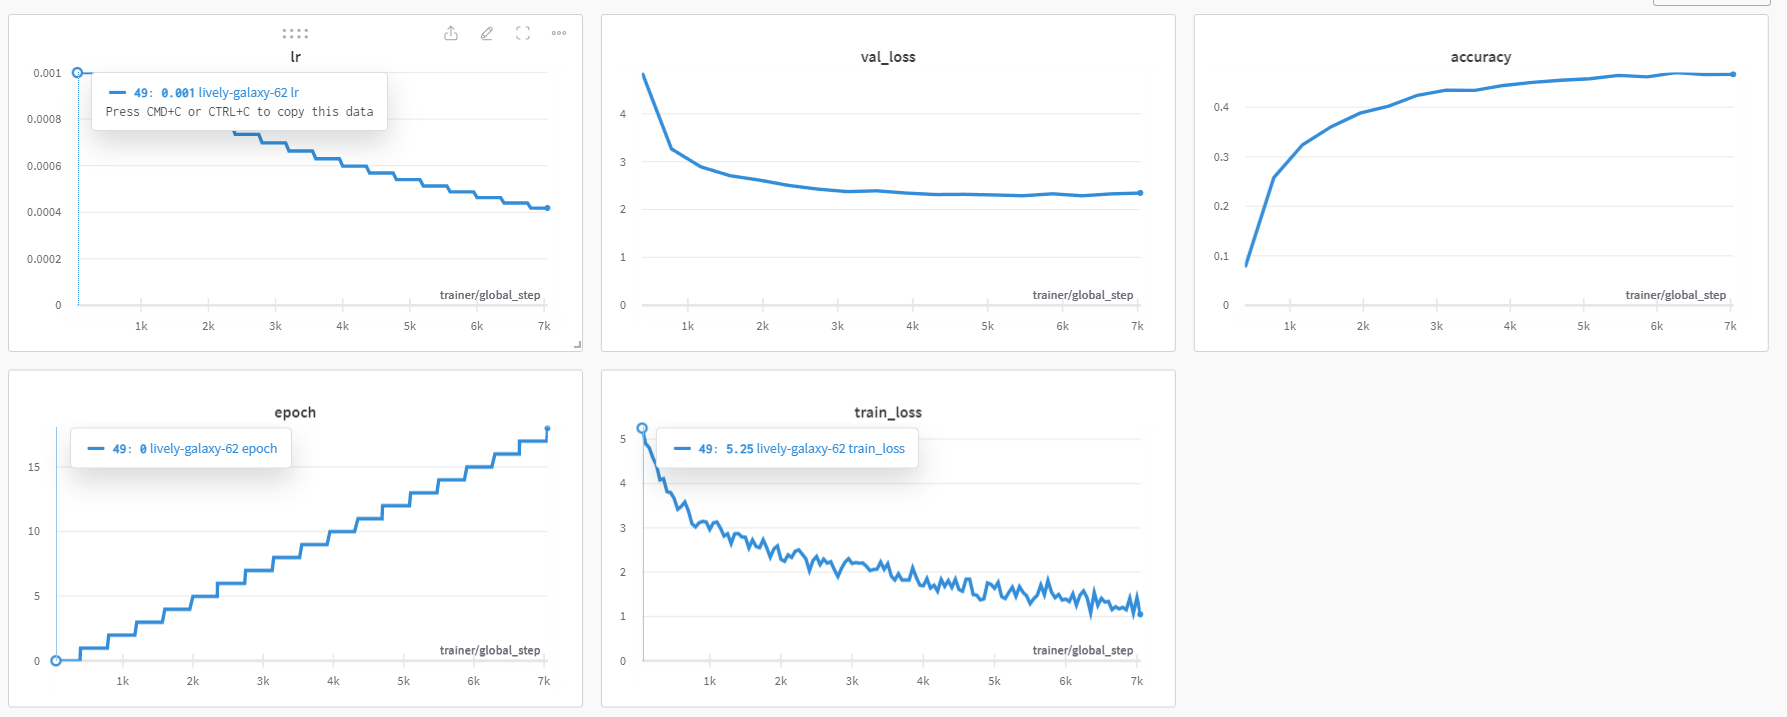


# Задание 2

Сначала я пробовал подгружать готовую модель и как есть дообучать, результаты были скромные, не больше 60% accuracy. На следующей итерации я попробовал ансамблировать модели предобученные и дообучать, результаты были получше (70%). Далее я вспомнил, что без заморозки весов, веса предобученной модели портятся. Поэтому я стал замораживать всю модель и дообучать только классификатор, результаты были около 65%. Тогда я понял, что потом нужно будет размораживать слои спустя какое-то время обучения, иначе мощности модельки не хватает. Я стал размораживать слои и добивался около 75-80% accuracy. Следующий шаг заключался в добавлении второго lr для слоев модели. Я понял, что слои самой модели нужно сначала с маленьким lr учить, а когда модель уже становится неплохой повышать lr. А lr классификатора наоборот сначала большой, потом уменьшать. Поэтому у меня появилось 2 scheduler для 2-х разных param_group. И это дало выбить 85% accuracy.
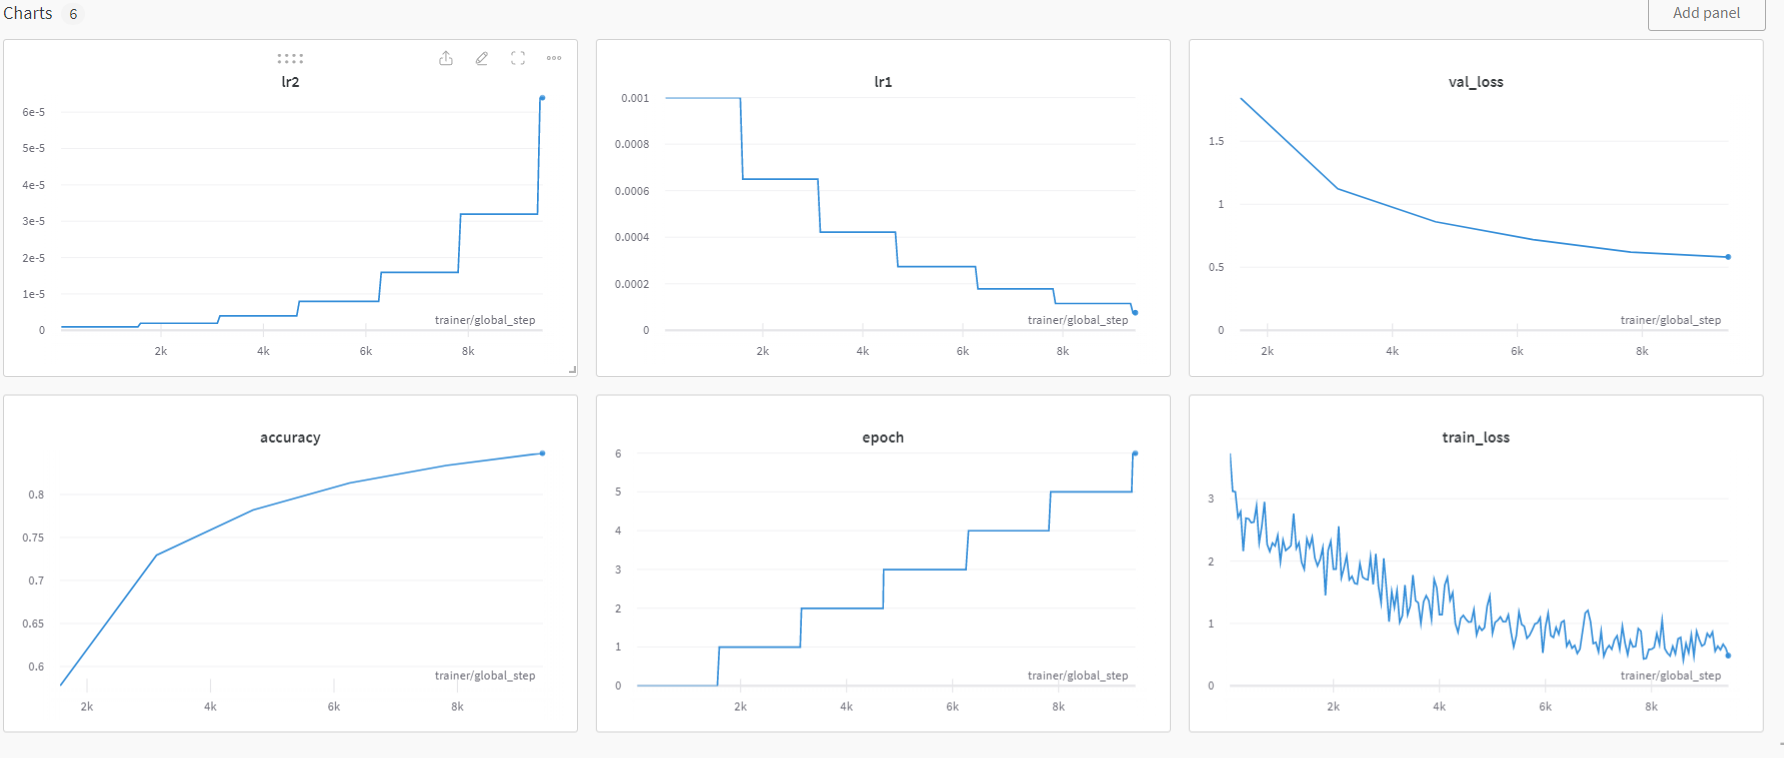